In [40]:
from itertools import product
import random
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64

## Define Model

In [42]:
class ToyModel(nn.Module):
    def __init__(self, digit_rep_dim,
                       internal_rep_dim,
                       encoder_width=50,
                       encoder_depth=3,
                       decoder_width=50,
                       decoder_depth=3,
                       activation=nn.Tanh,
                       device='cpu'):
        """A toy model for grokking with an encoder, a exact addition operation, and a decoder.
        
        Arguments:
            digit_rep_dim (int): Dimension of vectors representing symbols in binary op table
            internal_rep_dim (int): Dimension of encoded representation (usually 1 or 2)
            encoder_width (int): Width of MLP for the encoder
            encoder_depth (int): Depth of MLP for the encoder (a depth of 2 is 1 hidden layer)
            decoder_width (int): Width of MLP for the decoder
            decoder_depth (int): Depth of MLP for the decoder (a depth of 2 is 1 hidden layer)
            activation: PyTorch class for activation function to use for encoder/decoder MLPs
            device: device to put the encoder and decoder on
        """
        super(ToyModel, self).__init__()
        self.digit_rep_dim = digit_rep_dim
        
        # ------ Create Encoder ------
        encoder_layers = []
        for i in range(encoder_depth):
            if i == 0:
                encoder_layers.append(nn.Linear(digit_rep_dim, encoder_width))
                encoder_layers.append(activation())
            elif i == encoder_depth - 1:
                encoder_layers.append(nn.Linear(encoder_width, internal_rep_dim))
            else:
                encoder_layers.append(nn.Linear(encoder_width, encoder_width))
                encoder_layers.append(activation())
        self.encoder = nn.Sequential(*encoder_layers).to(device)
        
        # ------ Create Decoder ------
        decoder_layers = []
        for i in range(decoder_depth):
            if i == 0:
                decoder_layers.append(nn.Linear(internal_rep_dim, decoder_width))
                decoder_layers.append(activation())
            elif i == decoder_depth - 1:
                decoder_layers.append(nn.Linear(decoder_width, digit_rep_dim))
            else:
                decoder_layers.append(nn.Linear(decoder_width, decoder_width))
                decoder_layers.append(activation())
        self.decoder = nn.Sequential(*decoder_layers).to(device)
        
        
    def forward(self, x):
        """Runs the toy model on input `x`.
        
        `x` must contain vectors of dimension 2 * `digit_rep_dim`, since it represents a pair
        of symbols that we want to compute our binary operation between.
        """
        x1 = x[..., :self.digit_rep_dim]
        x2 = x[..., self.digit_rep_dim:]
        return self.decoder(self.encoder(x1) + self.encoder(x2))

## Define dataset

In [43]:
p = 10 # number of symbols along each axis of table
DIGIT_REP_DIM = 16

symbol_reps = dict()
for i in range(2 * p - 1):
    vec = torch.randn((1, DIGIT_REP_DIM))
    symbol_reps[i] = vec / torch.norm(vec, 2)
    
def get_i_from_rep(rep, symbol_reps):
    assert next(iter(symbol_reps.values())).shape == rep.shape
    for i, candidate_rep in symbol_reps.items():
        if torch.all(rep.to(candidate_rep.device) == candidate_rep):
            return i

In [44]:
table = dict()
pairs = [(i, j) for (i, j) in product(range(p), range(p)) if i <= j]
for (i, j) in pairs:
    table[(i, j)] = (i + j)
    
train_pairs = random.sample(pairs, int(len(pairs) * 0.75))
test_pairs = [pair for pair in pairs if pair not in train_pairs]

train_data = (
    torch.cat([torch.cat((symbol_reps[i], symbol_reps[j]), dim=1) for i, j in train_pairs], dim=0),
    torch.cat([symbol_reps[table[pair]] for pair in train_pairs])
)

test_data = (
    torch.cat([torch.cat((symbol_reps[i], symbol_reps[j]), dim=1) for i, j in test_pairs], dim=0),
    torch.cat([symbol_reps[table[pair]] for pair in test_pairs])
)

### Visualize data

Text(0.5, 1.0, 'all data')

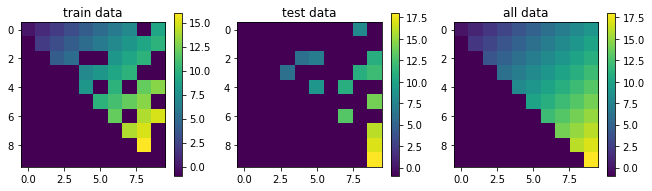

In [45]:
plt.figure(figsize=(11, 3))

all_visu = -1 * np.ones((p, p))

plt.subplot(1, 3, 1)
train_visu = -1 * np.ones((p, p))
for i, j in train_pairs:
    train_visu[i, j] = table[(i, j)]
    all_visu[i, j] = table[(i, j)]
plt.imshow(train_visu)
plt.colorbar()
plt.title("train data")

plt.subplot(1, 3, 2)
test_visu = -1 * np.ones((p, p))
for i, j in test_pairs:
    test_visu[i, j] = table[(i, j)]
    all_visu[i, j] = table[(i, j)]
plt.imshow(test_visu)
plt.colorbar()
plt.title("test data")

plt.subplot(1, 3, 3)
plt.imshow(all_visu)
plt.colorbar()
plt.title("all data")

### Train model

In [65]:
model = ToyModel(DIGIT_REP_DIM, 1, device=device)

In [66]:
optim = torch.optim.Adam([
            {'params': model.encoder.parameters()},
            {'params': model.decoder.parameters()}
        ])
loss_fn = nn.MSELoss()

In [67]:
def distance(x, y):
    assert x.shape == y.shape
    return torch.norm(x - y, 2)

In [68]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
steps = []

for step in tqdm(range(int(1e5))):
    optim.zero_grad()
    x, y_target = train_data
    x, y_target = x.to(device), y_target.to(device)
    y_train = model(x)
    l = loss_fn(y_target, y_train)
    
    if step % int(2e2) == 0:
        # record train accuracy and loss
        with torch.no_grad():
            correct = 0
            for i in range(x.shape[0]):
                closest_rep = min(symbol_reps.values(), key=lambda pos_rep: distance(pos_rep.to(device), y_train[i:i+1, ...]))
                pred_i = get_i_from_rep(closest_rep, symbol_reps)
                target_i = get_i_from_rep(y_target[i:i+1, ...], symbol_reps)
                if pred_i == target_i:
                    correct += 1
            steps.append(step)
            train_accuracies.append(correct / x.shape[0])
            train_losses.append(l.item())

        # record test accuracy and loss
        with torch.no_grad():
            x_test, y_test_target = test_data
            x_test, y_test_target = x_test.to(device), y_test_target.to(device)
            y_test = model(x_test)
            l_test = loss_fn(y_test_target, y_test)
            correct = 0
            for i in range(x_test.shape[0]):
                closest_rep = min(symbol_reps.values(), key=lambda pos_rep: distance(pos_rep.to(device), y_test[i:i+1, ...]))
                pred_i = get_i_from_rep(closest_rep, symbol_reps)
                target_i = get_i_from_rep(y_test_target[i:i+1, ...], symbol_reps)
                if pred_i == target_i:
                    correct += 1
            test_accuracies.append(correct / x_test.shape[0])
            test_losses.append(l_test.item())

    # backprop and step
    l.backward()
    optim.step()
    

  0%|          | 0/100000 [00:00<?, ?it/s]

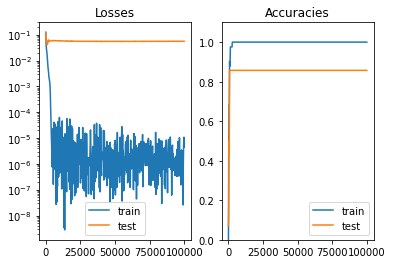

In [69]:
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, label='train')
plt.plot(steps, test_losses, label='test')
plt.yscale('log')
plt.title("Losses")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, test_accuracies, label='test')
plt.ylim(0, 1.1)
plt.title("Accuracies")
plt.legend()